In [47]:
import pandas as pd
import numpy as np
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import StandardScaler
np.random.seed(1337)

# Do not run the whole notebook! There are some sections which take very long (4+ hours) to run!

In [48]:
# load up the augmented processed GME data
processed_gme_data = pd.read_csv('GME_augmented_processed.csv')
processed_gme_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,RSI,SMA,LMA,ADX,up,Score,Sentiment
0,2021-02-17,49.770000,51.189999,44.560001,45.939999,45.939999,9186800.0,45.962590,110.887913,78.886475,26.642816,0,-0.173827,-1
1,2021-02-17,49.752222,51.157777,44.505695,45.867082,45.867082,9186800.0,45.953698,110.590784,78.899723,26.625878,0,-0.173827,-1
2,2021-02-17,49.734445,51.125555,44.451390,45.794166,45.794166,9186800.0,45.944800,110.295705,78.912937,26.608974,0,-0.173827,-1
3,2021-02-17,49.716667,51.093332,44.397084,45.721249,45.721249,9186800.0,45.935898,110.002673,78.926115,26.592103,0,-0.173827,-1
4,2021-02-17,49.698889,51.061110,44.342779,45.648332,45.648332,9186800.0,45.926990,109.711690,78.939260,26.575264,0,-0.173827,-1


# Side road: make sure I understand how to make a TimeSeriesGenerator

In [49]:
# load up the GME data
gme_data = pd.read_csv('GME.csv')
gme_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-01-04,19.000000,19.100000,17.15,17.250000,17.250000,10022500
1,2021-01-05,17.350000,18.080000,17.23,17.370001,17.370001,4961500
2,2021-01-06,17.340000,18.980000,17.33,18.360001,18.360001,6056200
3,2021-01-07,18.469999,19.450001,18.02,18.080000,18.080000,6129300
4,2021-01-08,18.180000,18.299999,17.08,17.690001,17.690001,6482000


In [50]:
gme_data = gme_data.loc[:, 'Open':'Close']
gme_data.head()

,Open,High,Low,Close
0,19.000000,19.100000,17.15,17.250000
1,17.350000,18.080000,17.23,17.370001
2,17.340000,18.980000,17.33,18.360001
3,18.469999,19.450001,18.02,18.080000
4,18.180000,18.299999,17.08,17.690001


In [51]:
# gme_split_point = int(len(gme_data)*0.7)
# print(gme_split_point)

# gme_train = gme_data[:gme_split_point]
# gme_test = gme_data[gme_split_point-w_size:]

In [52]:
# gme_test.head()

In [53]:
# target_test = gme_test.iloc[:, 3]
# target_test.head()

In [54]:
# target_test = target_test.to_numpy()

In [55]:
# gme_test = gme_test.to_numpy()

In [56]:
# gme_test.shape

In [57]:
# target_test.shape

In [58]:
# w_size = 2

# training_generator = TimeseriesGenerator(
#     data=gme_test,
#     targets=target_test,
# #     targets=training_labels,
#     length=w_size,
#     batch_size=1
# )


In [59]:
# counting = 0
# for thing in training_generator:
#     if counting == 5:
#         break
#     print(thing)
#     counting+=1

# Preprocessing

First thing to do is to process the data for the LSTM. We'll have to create windows of data to feed into the network.

need 'lag obeservations': https://machinelearningmastery.com/how-to-use-the-timeseriesgenerator-for-time-series-forecasting-in-keras/

In [60]:
# data is for 109 days
print(len(processed_gme_data)/72)

# get the split point
split_point = int(len(processed_gme_data)*0.7)
print(split_point)

# create a list of start of day indices to find the closest start of day index
start_of_day_indices = [i for i in range(0, len(processed_gme_data), 72)]

# find the start of day index that's closest to the split point
min_dist = math.inf
split_index = None
for start_of_day_index in start_of_day_indices:
    if abs(split_point-start_of_day_index) < min_dist:
        min_dist = abs(split_point-start_of_day_index)
        split_index = start_of_day_index

109.0
5493


So, training data will be using data from all days up to the 76th day (exclusive). In other words, training data uses 75 "full" days worth of data. Testing will use the rest of the data starting from the 76th day and onwards

In [61]:
# define a window size for the length parameter (to use for TimeseriesGenerator later)
window_size = 1

# separate the data to training and testing (approximately 70/30)
training = processed_gme_data[:split_index]
# offset by window_size since time series training will use input of window_size rows with output of the first row
testing = processed_gme_data[split_index - window_size:]

# separate each data group into data and labels
training_data = training.loc[:, 'Open':'Score']
# training_data = training.loc[:, 'Open':'ADX']
# training_labels = training.loc[:, 'up']

testing_data = testing.loc[:, 'Open':'Score']
# testing_data = testing.loc[:, 'Open':'ADX']
# testing_labels = testing.loc[:, 'up']

In [62]:
training_data.head()

,Open,High,Low,Close,Adj Close,Volume,RSI,SMA,LMA,ADX,up,Score
0,49.770000,51.189999,44.560001,45.939999,45.939999,9186800.0,45.962590,110.887913,78.886475,26.642816,0,-0.173827
1,49.752222,51.157777,44.505695,45.867082,45.867082,9186800.0,45.953698,110.590784,78.899723,26.625878,0,-0.173827
2,49.734445,51.125555,44.451390,45.794166,45.794166,9186800.0,45.944800,110.295705,78.912937,26.608974,0,-0.173827
3,49.716667,51.093332,44.397084,45.721249,45.721249,9186800.0,45.935898,110.002673,78.926115,26.592103,0,-0.173827
4,49.698889,51.061110,44.342779,45.648332,45.648332,9186800.0,45.926990,109.711690,78.939260,26.575264,0,-0.173827


In [63]:
# normalize training/testing data using standardscaler
# this also converts the data into numpy arrays (necessary for TimeseriesGenerator)
data_scaler = StandardScaler()
normalized_training_data = data_scaler.fit_transform(training_data)
# training_data_scaler = StandardScaler()
# training_data_scaler = training_data_scaler.fit(training_data)
# normalized_training_data = training_data_scaler.transform(training_data)
# normalized_training_data

# testing_data_scaler = StandardScaler()
# testing_data_scaler = testing_data_scaler.fit(testing_data)
# normalized_testing_data = testing_data_scaler.transform(testing_data)
normalized_testing_data = data_scaler.transform(testing_data)

In [64]:
# identify the label columns
normalized_training_labels = normalized_training_data[:, 10]
normalized_testing_labels = normalized_testing_data[:, 10]
print(normalized_training_labels)
print(normalized_testing_labels)
# training_labels

[-0.97402153 -0.97402153 -0.97402153 ...  1.02667135  1.02667135
  1.02667135]
[1.02667135 1.02667135 1.02667135 ... 1.02667135 1.02667135 1.02667135]


In [65]:
# testing_ts_generator

In [66]:
type(normalized_testing_data)

numpy.ndarray

In [67]:
actual_testing_labels = list(testing_data['up'])

In [68]:
# convert dataframe slices to numpy arrays for the timeseries generator
# training_data = np.array(training_data)
# training_labels = np.array(training_labels)
# testing_data = np.array(testing_data)
# testing_labels = np.array(testing_labels)

In [69]:
# create timeseries generators for training and testing data/labels
training_ts_generator = TimeseriesGenerator(
    data=normalized_training_data,
    targets=normalized_training_labels,
#     targets=training_labels,
    length=window_size,
    batch_size=1
)

testing_ts_generator = TimeseriesGenerator(
    data=normalized_testing_data,
    targets=normalized_testing_labels,
#     targets=testing_labels,
    length=window_size,
    batch_size=1
)

In [70]:
# processed_gme_data.head()

In [71]:
# just an example to see what output is
for i in range(len(training_ts_generator)):
    x, y = training_ts_generator[i]
    print('%s => %s' % (x, y))
    break

[[[-2.37120045 -2.40507799 -2.3988217  -2.45805618 -2.45805618
   -0.4053415  -1.059327   -1.01771832 -2.04087564  0.81276943
   -0.97402153 -3.06206343]]] => [-0.97402153]


In [72]:
# just an example to see what output is
for i in range(len(testing_ts_generator)):
    x, y = testing_ts_generator[i]
    print('%s => %s' % (x, y))
    break

[[[ 1.70357314  1.72573509  2.02874408  2.11192245  2.11192245
   -0.6397665   1.38802248  1.43679133  1.17929748  1.33863748
    1.02667135  0.32724309]]] => [1.02667135]


# LSTM

In [ ]:
# normalized_testing_data.shape
# training_ts_generator.shape

In [ ]:
# define an LSTM for the normalized training data
training_model = Sequential()
# input_shape for each data input is window_size x number of features (column) in training_data
training_model.add(LSTM(64, activation='sigmoid', input_shape=(window_size, 12), return_sequences=True))
training_model.add(LSTM(96, activation='sigmoid', return_sequences=False))
training_model.add(Dropout(0.2))

# output either standardized 0 or 1
training_model.add(Dense(1))

training_model.compile(optimizer='SGD', loss='mse')
training_model.summary()


In [666]:
%%time
history_train = training_model.fit(training_ts_generator, validation_data=testing_ts_generator ,epochs=5)

Epoch 1/10
5471/5471 [==============================] - 44s 6ms/step - loss: 1.0150 - val_loss: 0.0622
Epoch 2/10
5471/5471 [==============================] - 25s 5ms/step - loss: 0.1236 - val_loss: 0.0307
Epoch 3/10
5471/5471 [==============================] - 20s 4ms/step - loss: 0.0713 - val_loss: 0.0303
Epoch 4/10
5471/5471 [==============================] - 17s 3ms/step - loss: 0.0629 - val_loss: 0.0314
Epoch 5/10
5471/5471 [==============================] - 15s 3ms/step - loss: 0.0618 - val_loss: 0.0293
Epoch 6/10
5471/5471 [==============================] - 15s 3ms/step - loss: 0.0601 - val_loss: 0.0290
Epoch 7/10
5471/5471 [==============================] - 15s 3ms/step - loss: 0.0512 - val_loss: 0.0274
Epoch 8/10
5471/5471 [==============================] - 16s 3ms/step - loss: 0.0434 - val_loss: 0.0329
Epoch 9/10
5471/5471 [==============================] - 16s 3ms/step - loss: 0.0570 - val_loss: 0.0270
Epoch 10/10
5471/5471 [==============================] - 17s 3ms/step - l

In [667]:
history_train.history['loss']

[0.7400959134101868,
 0.10446109622716904,
 0.07319903373718262,
 0.06289176642894745,
 0.058874621987342834,
 0.05454050004482269,
 0.05240984261035919,
 0.04904453083872795,
 0.047557491809129715,
 0.04720359668135643]

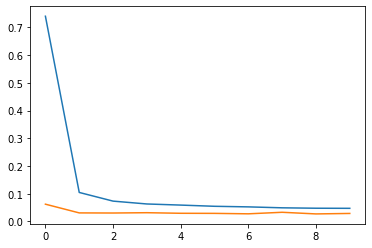

In [668]:
# history_train.history
plt.plot(history_train.history['loss'])
plt.plot(history_train.history['val_loss'])
plt.show()

In [669]:
training_results = training_model.predict(training_ts_generator)
testing_results = training_model.predict(testing_ts_generator)

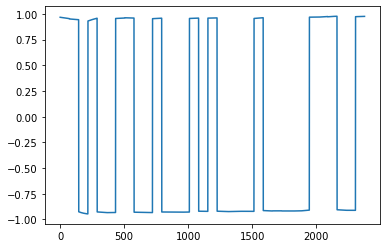

In [670]:
plt.plot(testing_results)

In [671]:
# results
prediction_results = training_model.predict(testing_ts_generator)

In [672]:
prediction_results

array([[0.96766746],
       [0.9672121 ],
       [0.96705437],
       ...,
       [0.9761629 ],
       [0.9761932 ],
       [0.97622323]], dtype=float32)

In [673]:
correctly_shaped_prediction_results = np.repeat(prediction_results, 12, axis=-1)
correctly_shaped_prediction_results

array([[0.96766746, 0.96766746, 0.96766746, ..., 0.96766746, 0.96766746,
        0.96766746],
       [0.9672121 , 0.9672121 , 0.9672121 , ..., 0.9672121 , 0.9672121 ,
        0.9672121 ],
       [0.96705437, 0.96705437, 0.96705437, ..., 0.96705437, 0.96705437,
        0.96705437],
       ...,
       [0.9761629 , 0.9761629 , 0.9761629 , ..., 0.9761629 , 0.9761629 ,
        0.9761629 ],
       [0.9761932 , 0.9761932 , 0.9761932 , ..., 0.9761932 , 0.9761932 ,
        0.9761932 ],
       [0.97622323, 0.97622323, 0.97622323, ..., 0.97622323, 0.97622323,
        0.97622323]], dtype=float32)

In [674]:
inverse_transform_results = data_scaler.inverse_transform(correctly_shaped_prediction_results)

In [675]:
binary_results = inverse_transform_results[:, 10]

In [676]:
correct_count = 0
ind = 0
correct_x = []
correct_y = []
wrong_x = []
wrong_y = []
for predicted_label, actual_label in zip(binary_results, actual_testing_labels):
    if predicted_label >= 0.5 and actual_label == 1:
        correct_count += 1
        correct_x.append(ind)
        correct_y.append(predicted_label)
    elif predicted_label < 0.5 and actual_label == 0:
        correct_count += 1
        correct_x.append(ind)
        correct_y.append(predicted_label)
    elif predicted_label >= 0.5 and actual_label == 0:
        wrong_x.append(ind)
        wrong_y.append(predicted_label)
    elif predicted_label < 0.5 and actual_label == 1:
        wrong_x.append(ind)
        wrong_y.append(predicted_label)
    ind+=1

# print out ratio of correct predictions
print(correct_count/len(actual_testing_labels))

0.992430613961312


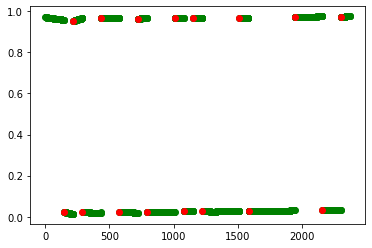

In [677]:
# plot the correct and incorrect predictions
plt.scatter(correct_x, correct_y, c='green')
plt.scatter(wrong_x, wrong_y, c='red')
# plt.scatter([x for x in range(len(actual_testing_labels))], actual_testing_labels)
plt.show()

# saving the model so far (for 72 time step case)

In [521]:
# training_model.save('./keras_models/lstm_sentiment_72_sequence_20_epoch')

INFO:tensorflow:Assets written to: ./keras_models/lstm_sentiment_72_sequence_20_epoch/assets


# stuff below here is optional in running

# thoughts for lstm with sentiment data

The results compared to LSTM without sentiment data are essentially negligible. One fundamental reason behind this may be the erratic behaviour of the posters and commenters behind the subreddits we have taken data from. Those being r/superstonk, r/GME, and r/wallstreetbets. All these subreddits generally have a very strong positive bias towards buying or holding onto shares.

Another fundamental reason behind this is that, perhaps some posts and comments are reactionary, meaning the sentiment scores are lagging behind the price values. For example, people may talk positively about a stock only once it has gone up. Similarly, people will only talk negatively about a stock once prices have already gone done, or are currently going down.

302.559998
[0.15183765 0.15159665 0.15135565 ... 0.59590523 0.59597454 0.59604386]


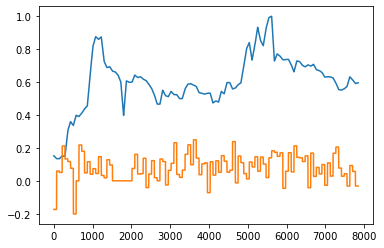

In [248]:
# try plotting out closing prices and sentiment scores on the same graph
close_prices = processed_gme_data['Close']
max_close_price = np.max(close_prices)
print(max_close_price)
close_prices = np.array(close_prices)
close_prices /= max_close_price
print(close_prices)

plt.plot(close_prices)
plt.plot(processed_gme_data['Score'])

To try and find quantifiable reasons behind this, check the correlation between closing prices and the sentiment scores of the reddit data.

In [296]:
sentiment_scores = np.array(processed_gme_data['Score'])
correlation_values = np.corrcoef(close_prices, sentiment_scores)
correlation_values

array([[1.        , 0.14031801],
       [0.14031801, 1.        ]])

Interestingly, there is a small postitive correlation between the closing prices and the sentiment data (0.14), although it's fairly weak.

One very large problem is that the closing prices are linearly interpolated. See if the correlation is better or worse when the actual data from each day is used

In [526]:
back_to_original_gme = processed_gme_data.iloc[::72, :]
back_to_original_gme

,Date,Open,High,Low,Close,Adj Close,Volume,RSI,SMA,LMA,ADX,up,Score,Sentiment
0,2021-02-17,49.770000,51.189999,44.560001,45.939999,45.939999,9186800.0,45.962590,110.887913,78.886475,26.642816,0,-0.173827,-1
72,2021-02-18,48.490002,48.869999,40.650002,40.689999,40.689999,23990600.0,45.308582,94.730224,79.752066,25.506572,0,0.059177,0
144,2021-02-19,41.279999,43.889999,38.500000,40.590000,40.590000,14828200.0,45.295396,79.046424,80.510980,24.514069,1,0.051113,0
216,2021-02-22,46.689999,48.509998,42.400002,46.000000,46.000000,19476000.0,46.205108,62.548353,81.348130,23.544155,0,0.211640,1
288,2021-02-23,44.970001,46.230000,40.000000,44.970001,44.970001,7565200.0,46.048515,54.613735,82.267982,22.605417,1,0.133193,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7488,2021-07-16,170.149994,179.470001,166.300003,169.039993,169.039993,3278800.0,35.231303,193.645283,216.464699,17.787849,1,0.042680,0
7560,2021-07-19,163.300003,176.000000,161.220001,173.490005,173.490005,2436900.0,37.945254,190.780278,213.734502,18.345848,1,-0.031753,0
7632,2021-07-20,173.899994,193.639999,172.419998,191.179993,191.179993,3101100.0,47.362702,188.666657,211.002937,18.329639,0,0.092567,0
7704,2021-07-21,187.789993,195.509995,182.110001,185.809998,185.809998,2225900.0,45.129630,186.947019,207.613400,17.686936,0,0.057170,0


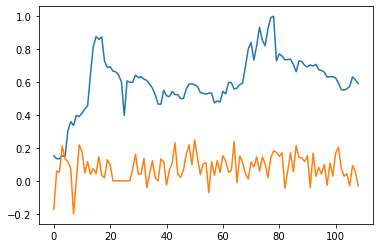

In [575]:
# try plotting out closing prices and sentiment scores on the same graph with "actual" data
close_prices = back_to_original_gme['Close']
max_close_price = np.max(close_prices)
# print(max_close_price)
close_prices = np.array(close_prices)
close_prices /= max_close_price
# print(close_prices)
scores = back_to_original_gme['Score'].values
scores = np.array(scores)

min_close_price = np.min(close_prices)
# scores += 0.2
# print(scores)
# print(len(close_prices))
# print(len(back_to_original_gme['Score']))
plt.plot(close_prices)
plt.plot(scores)

In [542]:
correlation_values = np.corrcoef(close_prices, scores)
correlation_values

array([[1.        , 0.14083053],
       [0.14083053, 1.        ]])

correlation increased only by about 7 ten-thousandths. Not a very large amount.

# BELOW USED FOR TESTING. RUN OPTIONALLY (takes excessively long time[4-5 hours])

# testing different values of time step for accuracy

In [73]:
window_accuracies_sigmoid = []
for window in range (1,10):
    training_ts_generator = TimeseriesGenerator(
        data=normalized_training_data,
        targets=normalized_training_labels,
    #     targets=training_labels,
        length=window,
        batch_size=1
    )

    testing_ts_generator = TimeseriesGenerator(
        data=normalized_testing_data,
        targets=normalized_testing_labels,
    #     targets=testing_labels,
        length=window,
        batch_size=1
    ) 
    training_model = Sequential()
    # input_shape for each data input is window_size x number of features (column) in training_data
    training_model.add(LSTM(64, activation='sigmoid', input_shape=(window, 12), return_sequences=True))
    training_model.add(LSTM(96, activation='sigmoid', return_sequences=False))
    training_model.add(Dropout(0.2))

    # output either standardized 0 or 1
    training_model.add(Dense(1))

    training_model.compile(optimizer='SGD', loss='mse')
    training_model.summary()
    
    history_train = training_model.fit(training_ts_generator, validation_data=testing_ts_generator, epochs=3)
    
#     training_results = training_model.evaluate(training_ts_generator)
#     testing_results = training_model.evaluate(testing_ts_generator)
    
    prediction_results = training_model.predict(testing_ts_generator)
    
    correctly_shaped_prediction_results = np.repeat(prediction_results, 12, axis=-1)

    inverse_transform_results = data_scaler.inverse_transform(correctly_shaped_prediction_results)
    
    binary_results = inverse_transform_results[:, 10]
    
    predicted_testing_labels = []
    for label in binary_results:
        if label >= 0.5:
            predicted_testing_labels.append(1)
        else:
            predicted_testing_labels.append(0)
            
    correct_count = 0
    for predicted_label, actual_label in zip(predicted_testing_labels, actual_testing_labels):
        if predicted_label == actual_label:
            correct_count += 1
    print(correct_count)
    print(len(actual_testing_labels))

    # print out correct ratio
    current_accuracy = correct_count/len(actual_testing_labels)
    print(current_accuracy)
    window_accuracies_sigmoid.append(current_accuracy)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 1, 64)             19712     
_________________________________________________________________
lstm_3 (LSTM)                (None, 96)                61824     
_________________________________________________________________
dropout_1 (Dropout)          (None, 96)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 97        
Total params: 81,633
Trainable params: 81,633
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
5471/5471 [==============================] - 20s 3ms/step - loss: 0.9503 - val_loss: 0.0482
Epoch 2/3
5471/5471 [==============================] - 22s 4ms/step - loss: 0.1113 - val_loss: 0.0618
Epoch 3/3
5471/5471 [=======================

5465/5465 [==============================] - 43s 7ms/step - loss: 0.8134 - val_loss: 0.0490
Epoch 2/3
5465/5465 [==============================] - 40s 7ms/step - loss: 0.0737 - val_loss: 0.0376
Epoch 3/3
5465/5465 [==============================] - 39s 7ms/step - loss: 0.0596 - val_loss: 0.0341
2274
2377
0.9566680689945309
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 8, 64)             19712     
_________________________________________________________________
lstm_17 (LSTM)               (None, 96)                61824     
_________________________________________________________________
dropout_8 (Dropout)          (None, 96)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 97        
Total params: 81,633
Trainable params: 81,633
Non-trainable

In [74]:
window_accuracies_relu = []
for window in range (1,10):
    training_ts_generator = TimeseriesGenerator(
        data=normalized_training_data,
        targets=normalized_training_labels,
    #     targets=training_labels,
        length=window,
        batch_size=1
    )

    testing_ts_generator = TimeseriesGenerator(
        data=normalized_testing_data,
        targets=normalized_testing_labels,
    #     targets=testing_labels,
        length=window,
        batch_size=1
    ) 
    training_model = Sequential()
    # input_shape for each data input is window_size x number of features (column) in training_data
    training_model.add(LSTM(64, activation='relu', input_shape=(window, 12), return_sequences=True))
    training_model.add(LSTM(96, activation='relu', return_sequences=False))
    training_model.add(Dropout(0.2))

    # output either standardized 0 or 1
    training_model.add(Dense(1))

    training_model.compile(optimizer='SGD', loss='mse')
    training_model.summary()
    
    history_train = training_model.fit(training_ts_generator, validation_data=testing_ts_generator, epochs=3)
    
#     training_results = training_model.evaluate(training_ts_generator)
#     testing_results = training_model.evaluate(testing_ts_generator)
    
    prediction_results = training_model.predict(testing_ts_generator)
    
    correctly_shaped_prediction_results = np.repeat(prediction_results, 12, axis=-1)

    inverse_transform_results = data_scaler.inverse_transform(correctly_shaped_prediction_results)
    
    binary_results = inverse_transform_results[:, 10]
    
    predicted_testing_labels = []
    for label in binary_results:
        if label >= 0.5:
            predicted_testing_labels.append(1)
        else:
            predicted_testing_labels.append(0)
            
    correct_count = 0
    for predicted_label, actual_label in zip(predicted_testing_labels, actual_testing_labels):
        if predicted_label == actual_label:
            correct_count += 1
    print(correct_count)
    print(len(actual_testing_labels))

    # print out correct ratio
    current_accuracy = correct_count/len(actual_testing_labels)
    print(current_accuracy)
    window_accuracies_relu.append(current_accuracy)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_20 (LSTM)               (None, 1, 64)             19712     
_________________________________________________________________
lstm_21 (LSTM)               (None, 96)                61824     
_________________________________________________________________
dropout_10 (Dropout)         (None, 96)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 97        
Total params: 81,633
Trainable params: 81,633
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
5471/5471 [==============================] - 23s 3ms/step - loss: 0.6039 - val_loss: 0.0287
Epoch 2/3
5471/5471 [==============================] - 16s 3ms/step - loss: 0.0385 - val_loss: 0.0289
Epoch 3/3
5471/5471 [======================

5465/5465 [==============================] - 45s 7ms/step - loss: 0.2002 - val_loss: 0.0633
Epoch 2/3
5465/5465 [==============================] - 37s 7ms/step - loss: 0.0695 - val_loss: 0.0549
Epoch 3/3
5465/5465 [==============================] - 36s 7ms/step - loss: 0.0580 - val_loss: 0.0380
2286
2377
0.9617164493058477
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_34 (LSTM)               (None, 8, 64)             19712     
_________________________________________________________________
lstm_35 (LSTM)               (None, 96)                61824     
_________________________________________________________________
dropout_17 (Dropout)         (None, 96)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 97        
Total params: 81,633
Trainable params: 81,633
Non-trainabl

In [75]:
window_accuracies_softmax = []
for window in range (1,10):
    training_ts_generator = TimeseriesGenerator(
        data=normalized_training_data,
        targets=normalized_training_labels,
    #     targets=training_labels,
        length=window,
        batch_size=1
    )

    testing_ts_generator = TimeseriesGenerator(
        data=normalized_testing_data,
        targets=normalized_testing_labels,
    #     targets=testing_labels,
        length=window,
        batch_size=1
    ) 
    training_model = Sequential()
    # input_shape for each data input is window_size x number of features (column) in training_data
    training_model.add(LSTM(64, activation='softmax', input_shape=(window, 12), return_sequences=True))
    training_model.add(LSTM(96, activation='softmax', return_sequences=False))
    training_model.add(Dropout(0.2))

    # output either standardized 0 or 1
    training_model.add(Dense(1))

    training_model.compile(optimizer='SGD', loss='mse')
    training_model.summary()
    
    history_train = training_model.fit(training_ts_generator, validation_data=testing_ts_generator, epochs=3)
    
#     training_results = training_model.evaluate(training_ts_generator)
#     testing_results = training_model.evaluate(testing_ts_generator)
    
    prediction_results = training_model.predict(testing_ts_generator)
    
    correctly_shaped_prediction_results = np.repeat(prediction_results, 12, axis=-1)

    inverse_transform_results = data_scaler.inverse_transform(correctly_shaped_prediction_results)
    
    binary_results = inverse_transform_results[:, 10]
    
    predicted_testing_labels = []
    for label in binary_results:
        if label >= 0.5:
            predicted_testing_labels.append(1)
        else:
            predicted_testing_labels.append(0)
            
    correct_count = 0
    for predicted_label, actual_label in zip(predicted_testing_labels, actual_testing_labels):
        if predicted_label == actual_label:
            correct_count += 1
    print(correct_count)
    print(len(actual_testing_labels))

    # print out correct ratio
    current_accuracy = correct_count/len(actual_testing_labels)
    print(current_accuracy)
    window_accuracies_softmax.append(current_accuracy)

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_38 (LSTM)               (None, 1, 64)             19712     
_________________________________________________________________
lstm_39 (LSTM)               (None, 96)                61824     
_________________________________________________________________
dropout_19 (Dropout)         (None, 96)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 97        
Total params: 81,633
Trainable params: 81,633
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
5471/5471 [==============================] - 21s 3ms/step - loss: 1.0120 - val_loss: 1.0322
Epoch 2/3
5471/5471 [==============================] - 15s 3ms/step - loss: 1.0120 - val_loss: 0.9975
Epoch 3/3
5471/5471 [======================

5465/5465 [==============================] - 46s 8ms/step - loss: 1.0134 - val_loss: 0.9738
Epoch 2/3
5465/5465 [==============================] - 40s 7ms/step - loss: 1.0123 - val_loss: 0.9852
Epoch 3/3
5465/5465 [==============================] - 43s 8ms/step - loss: 1.0127 - val_loss: 0.9991
1440
2377
0.6058056373580143
Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_52 (LSTM)               (None, 8, 64)             19712     
_________________________________________________________________
lstm_53 (LSTM)               (None, 96)                61824     
_________________________________________________________________
dropout_26 (Dropout)         (None, 96)                0         
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 97        
Total params: 81,633
Trainable params: 81,633
Non-trainabl

In [76]:
# save this in case of another power surge
# below values are for sigmoid activation function
# window_accuracies = [
#     0.9995794785534062,
#     0.992430613961312,
#     0.9852817493692179,
#     0.9781328847771237,
#     0.9709840201850294,
#     0.9638351555929352,
#     0.956686291000841,
#     0.9495374264087468,
#     0.9423885618166526,
#     0.9386038687973086,
#     0.9280908326324643,
#     0.9209419680403701,
#     0.9137931034482759,
#     0.9066442388561816,
#     0.8994953742640874,
#     0.8923465096719932,
#     0.8851976450798991,
#     0.8780487804878049,
#     0.8708999158957107 
# ]

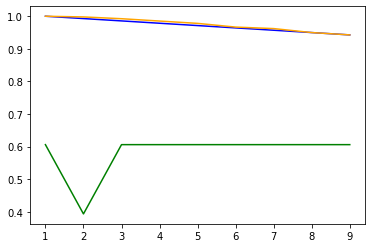

In [82]:
plt.plot([i for i in range(1, 10)], window_accuracies_sigmoid, c='blue')
plt.plot([i for i in range(1, 10)], window_accuracies_relu, c='orange')
plt.plot([i for i in range(1, 10)], window_accuracies_softmax, c='green')
plt.show()

In [78]:
window_accuracies_softmax

[0.6058056373580143,
 0.3933529659234329,
 0.6058056373580143,
 0.6058056373580143,
 0.6058056373580143,
 0.6058056373580143,
 0.6058056373580143,
 0.6058056373580143,
 0.6058056373580143]

In [85]:
window_accuracies

[0.9995794785534062,
 0.992430613961312,
 0.9852817493692179,
 0.9781328847771237,
 0.9709840201850294,
 0.9638351555929352,
 0.956686291000841,
 0.9495374264087468,
 0.9423885618166526,
 0.9386038687973086,
 0.9280908326324643,
 0.9209419680403701,
 0.9137931034482759,
 0.9066442388561816,
 0.8994953742640874,
 0.8923465096719932,
 0.8851976450798991,
 0.8780487804878049,
 0.8708999158957107]

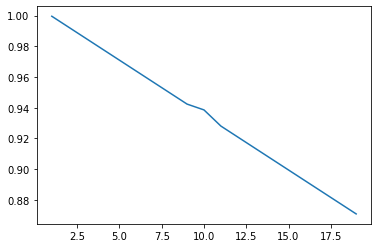

In [88]:
plt.plot([i for i in range(1,20)], window_accuracies)

# Cross Validation

In [ ]:
activation_funcs = ['relu', 'sigmoid', 'softmax']
node_values = [val for val in range(32, 129, 32)]
drop_values = [0.2, 0.3, 0.4, 0.5]
node_values

In [ ]:
# %%time
# history_train = training_model.fit(training_ts_generator, epochs=5)

In [ ]:
# training_results = training_model.evaluate(training_ts_generator)
# testing_results = training_model.evaluate(testing_ts_generator)

In [ ]:
# training_results
history_train.history

In [ ]:
# runs for around 4 hours! avoid running if possible!!!!

# define min_loss
min_loss = math.inf

# define best hyper params to use
best_func = None
best_first_hidden_nodes = None
best_second_hidden_nodes = None
best_dropout = None

for activation_func in activation_funcs:
    for i in range(len(node_values)):
        for j in range(len(node_values)):
            for drop_value in drop_values:
                
                # define an LSTM for the normalized training data
                cross_valid_model = Sequential()
                # input_shape for each data input is window_size x number of features (column) in training_data
                cross_valid_model.add(
                    LSTM(
                        node_values[i],
                        activation=activation_func,
                        input_shape=(window_size, 11),
                        return_sequences=True
                    )
                )
                cross_valid_model.add(
                    LSTM(
                        node_values[j],
                        activation=activation_func,
                        return_sequences=False
                    )
                )
                cross_valid_model.add(Dropout(drop_value))

                # output either standardized 0 or 1
                cross_valid_model.add(Dense(1))

                # leaving optimizer and loss funcs as-is
                cross_valid_model.compile(optimizer='SGD', loss='mse')
                
                # fit data to the cross_validation model
                cross_valid_model.fit(training_ts_generator, epochs=5)
                
                # training/testing loss values
                cross_valid_train_loss = cross_valid_model.evaluate(training_ts_generator)
                cross_valid_test_loss = cross_valid_model.evaluate(testing_ts_generator)
                
                if cross_valid_test_loss < min_loss:
                    best_func = activation_func
                    best_first_hidden_nodes = node_values[i]
                    best_second_hidden_nodes = node_values[j]
                    best_dropout = drop_value
                    min_loss = cross_valid_test_loss
                    print(f'{best_func}, {best_first_hidden_nodes}, {best_second_hidden_nodes}, {best_dropout}')
                    print(min_loss)
                
# cross_valid_model.summary()


In [ ]:
print(best_func)
print(best_first_hidden_nodes)
print(best_second_hidden_nodes)
print(best_dropout)
print(min_loss)